In [2]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 86 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638153 sha256=239f1f759e550e13874d3c0cabd32ad34ea00f68b27ba1a689bbaba1075ce37b
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.4
    Uninstalling cmdstanpy-1.0.4:
      Successfully uninstalled cmdstanpy-1.0.4
ERROR: pip's dependency resolver does not currently take into account all the p

Carga de librerias

In [293]:
#Se cargan las librerias a utilizar
import pandas as pd 
import fbprophet as Prophet
from matplotlib import pyplot as plt

Carga de los datos

In [294]:
# Se cargan los datos a analizar
dfdatos = pd.read_csv('data_test(2).csv')
dfdatos

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,2022-04-23 00:00:00,1490.46,0.00,PAID
1,93,11,18660730,2021-11-20 00:00:00,6418.28,624.48,PAID
2,122,12,18660731,2021-10-19 00:00:00,27979.20,10520.15,PAID
3,85,13,18660732,2021-11-13 00:00:00,183070.77,79421.63,PAID
4,87,14,18660733,2022-03-23 00:00:00,20532.00,20532.00,PAID
...,...,...,...,...,...,...,...
1195,9,16,18661924,NaN,1281.86,0.00,FAILED
1196,135,80,18661925,NaN,1147.86,0.00,FAILED
1197,61,16,18661926,NaN,1490.46,0.00,FAILED
1198,36,154,18661927,NaN,800.66,0.00,FAILED


Limpieza y ajuste de los datos

In [295]:
#Primeramente para el modelo a trabajar con prophet es necesario quitar los datos nulos que no se van a utilizar, en este caso las que llevan el status FAILED y tienen NaN en fecha
dfdatos = dfdatos[dfdatos['paidAt'].notna()]
#Ordenas datos por fecha de la más reciente a la más antigua
dfdatos = dfdatos.sort_values(by='paidAt', ascending=False)
#Se asegura el date format para la columna con fechas y se cambia el formato de fecha solo día, mes, año
dfdatos['paidAt'] = pd.to_datetime(dfdatos.paidAt)
dfdatos['paidAt'] = dfdatos['paidAt'].dt.strftime('%Y-%m-%d')
#dfdatos['Total Amount'] = dfdatos['amount'] + dfdatos['amountfinancedByXepelin']
dfdatos 



,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
134,164,113,18660863,2022-05-31,1490.46,0.00,PAID
135,17,16,18660864,2022-05-31,13989.60,0.00,PAID
136,58,14,18660865,2022-05-31,1041.26,0.00,PAID
137,184,14,18660866,2022-05-31,1490.46,0.00,PAID
574,36,98,18661303,2022-05-30,1490.46,0.00,PAID
...,...,...,...,...,...,...,...
12,55,34,18660741,2021-10-31,1477.46,0.00,PAID
2,122,12,18660731,2021-10-19,27979.20,10520.15,PAID
15,114,37,18660744,2021-10-16,4035.26,0.00,PAID
8,126,18,18660737,2021-10-09,920.26,0.00,PAID


In [296]:
#Se toman solo las columnas necesarias para incorporar al modelo y  estimar el dinero que se moverá en Xepelin durante junio 2022
dfdatos = dfdatos[['paidAt', 'amount' ]]
#Se cambia el nombre de las columnas standard para que el modelo pueda cargar la información
dfdatos.columns = ['ds', 'y']
#dfdatos = dfdatos.sort_values(by='ds', ascending=True)
dfdatos

,ds,y
134,2022-05-31,1490.46
135,2022-05-31,13989.60
136,2022-05-31,1041.26
137,2022-05-31,1490.46
574,2022-05-30,1490.46
...,...,...
12,2021-10-31,1477.46
2,2021-10-19,27979.20
15,2021-10-16,4035.26
8,2021-10-09,920.26


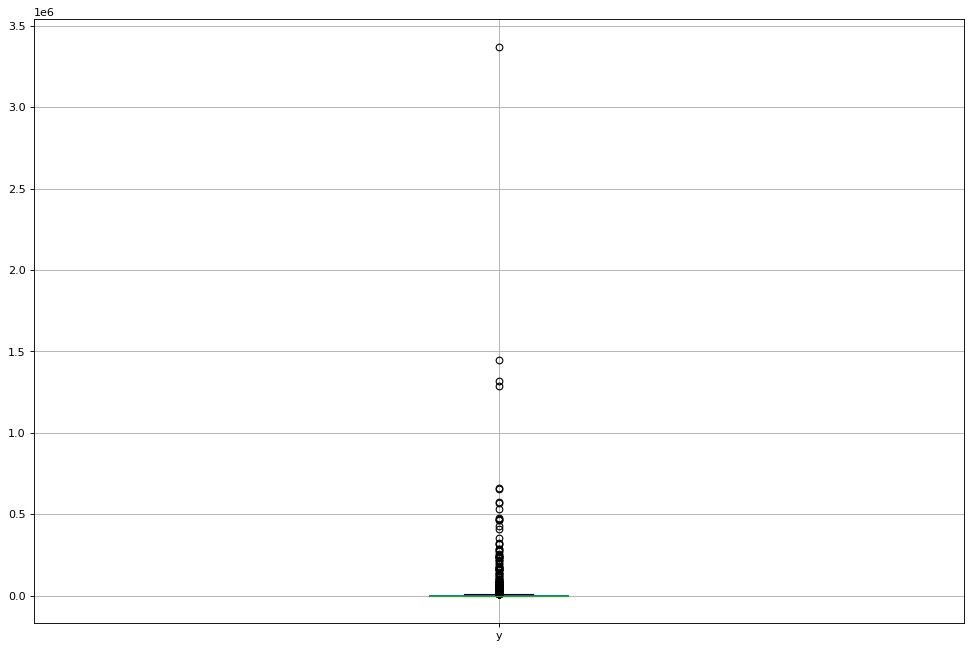

In [297]:
#Visualizamosm los datos con un boxplot para observar posibles outliers en los datos que afecten al modelo

from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)
dfdatos.boxplot(column=['y']) 

In [298]:
#Eliminamos los datos que consideramos outliers, que a simple vista sería el valor que está por encima de 1.5
dfdatos = dfdatos[dfdatos['y'] < 1000000]

In [299]:
#Consolidamos la información granulada en periodos mensuales y sumamos los montos

dfdatos['ds'] = pd.to_datetime(dfdatos['ds'])
grouped = dfdatos.groupby(dfdatos['ds'].dt.to_period('m')).sum().reset_index()
grouped

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2021-10,35902.64
1,2021-11,268349.19
2,2021-12,753946.49
3,2022-01,3912303.60
4,2022-02,4498019.86
5,2022-03,4318322.35
6,2022-04,5042399.69
7,2022-05,1180788.62


In [301]:
#Se da formato a la columna de fecha
grouped['ds'] = grouped['ds'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')
lendatos = len(grouped)
grouped

,ds,y
0,2021-10-01,35902.64
1,2021-11-01,268349.19
2,2021-12-01,753946.49
3,2022-01-01,3912303.60
4,2022-02-01,4498019.86
5,2022-03-01,4318322.35
6,2022-04-01,5042399.69
7,2022-05-01,3186188.62


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


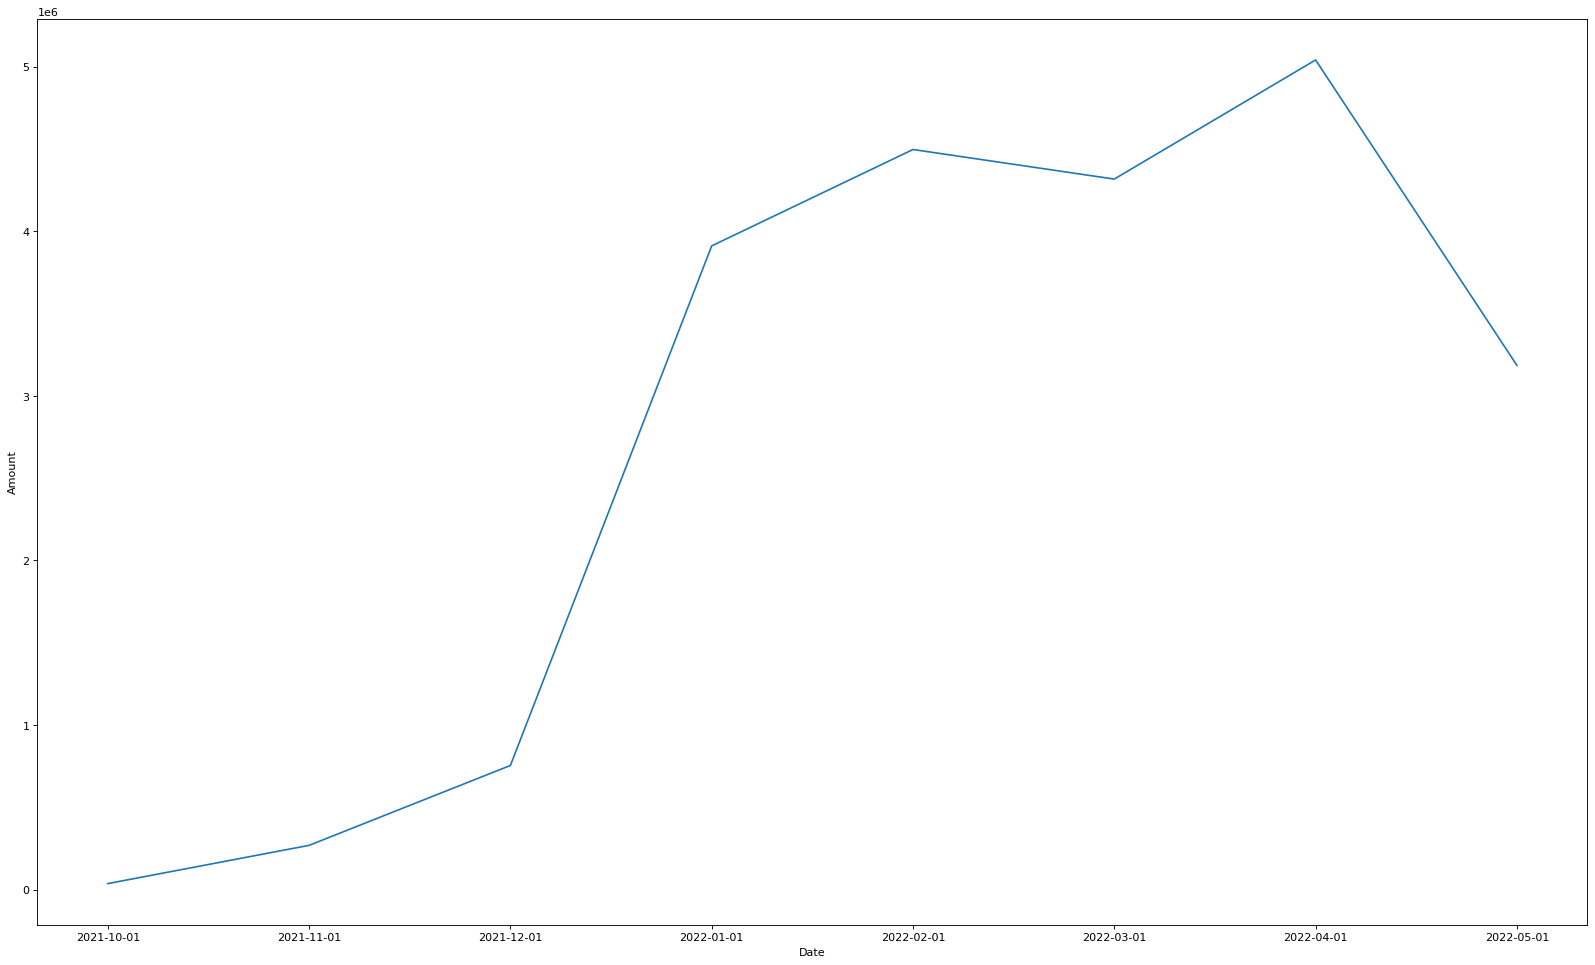

In [302]:
#Previsualizamos los datos de manera mensual

figure(figsize=(25, 15), dpi=80)
grouped = grouped.sort_values('ds', ascending=True)
plt.xlabel('Date')
plt.ylabel('Amount')
plt.plot(grouped['ds'], grouped['y'])
plt.show()

In [308]:
#Cargamos el modelo en este caso Prophet, con una estacionalidad semanal y un intervalo de anomalia del .90
m = Prophet.Prophet(interval_width= 0.90,weekly_seasonality=True,  n_changepoints=5)
m.fit(grouped)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [309]:
#Cargamos los datos futuros a predecir, en periodos mensuales

datosfuture = m.make_future_dataframe(periods=3, freq = 'm')
datosfuture

,ds
0,2021-10-01
1,2021-11-01
2,2021-12-01
3,2022-01-01
4,2022-02-01
5,2022-03-01
6,2022-04-01
7,2022-05-01
8,2022-05-31
9,2022-06-30


In [310]:
#Predecimos los datos datos futuros con el modelo
prediction = m.predict(datosfuture)
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-10-01,-2.004684e+05,-2.666899e+05,5.033837e+05,-2.004684e+05,-2.004684e+05,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,0.0,0.0,0.0,1.078599e+05
1,2021-11-01,6.277733e+05,-1.333620e+05,6.244421e+05,6.277733e+05,6.277733e+05,-3.594153e+05,-3.594153e+05,-3.594153e+05,-3.594153e+05,-3.594153e+05,-3.594153e+05,0.0,0.0,0.0,2.683579e+05
2,2021-12-01,1.429298e+06,3.567627e+05,1.114141e+06,1.429298e+06,1.429298e+06,-6.753404e+05,-6.753404e+05,-6.753404e+05,-6.753404e+05,-6.753404e+05,-6.753404e+05,0.0,0.0,0.0,7.539571e+05
3,2022-01-01,2.257539e+06,3.525238e+06,4.294649e+06,2.257539e+06,2.257539e+06,1.654748e+06,1.654748e+06,1.654748e+06,1.654748e+06,1.654748e+06,1.654748e+06,0.0,0.0,0.0,3.912287e+06
4,2022-02-01,3.085781e+06,3.647549e+06,4.413843e+06,3.085781e+06,3.085781e+06,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,0.0,0.0,0.0,4.034121e+06
5,2022-03-01,3.833870e+06,4.440975e+06,5.152973e+06,3.833870e+06,3.833870e+06,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,0.0,0.0,0.0,4.782211e+06
6,2022-04-01,4.662112e+06,4.599151e+06,5.351370e+06,4.662112e+06,4.662112e+06,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,3.083284e+05,0.0,0.0,0.0,4.970440e+06
7,2022-05-01,5.463636e+06,2.834472e+06,3.584108e+06,5.463636e+06,5.463636e+06,-2.277431e+06,-2.277431e+06,-2.277431e+06,-2.277431e+06,-2.277431e+06,-2.277431e+06,0.0,0.0,0.0,3.186205e+06
8,2022-05-31,6.265160e+06,6.827626e+06,7.590857e+06,6.265160e+06,6.265160e+06,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,9.483404e+05,0.0,0.0,0.0,7.213501e+06
9,2022-06-30,7.066685e+06,7.101271e+06,7.884872e+06,7.066685e+06,7.066685e+06,4.007703e+05,4.007703e+05,4.007703e+05,4.007703e+05,4.007703e+05,4.007703e+05,0.0,0.0,0.0,7.467455e+06


<Figure size 1600x800 with 0 Axes>

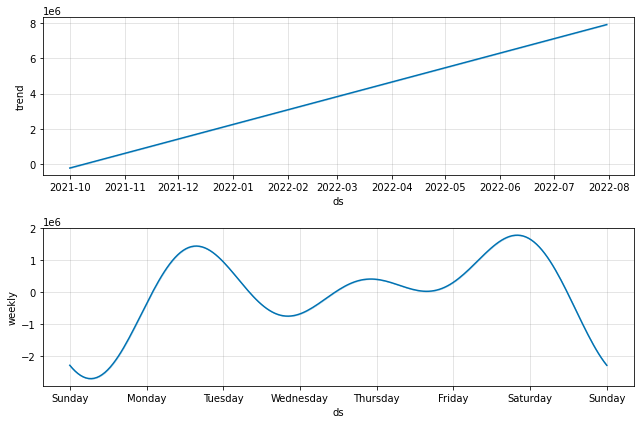

In [311]:
#Ploteamos la tendencia de los datos y la estacionalidad marcada en los datos de manera semanal

figure(figsize=(20, 10), dpi=80)
plot2 = m.plot_components(prediction)

In [307]:
#Visualizamos los datos predecidos

from prophet.plot import plot_plotly, plot_components_plotly
figure(figsize=(20, 10), dpi=80)
plot_plotly(m, prediction)

<Figure size 1600x800 with 0 Axes>

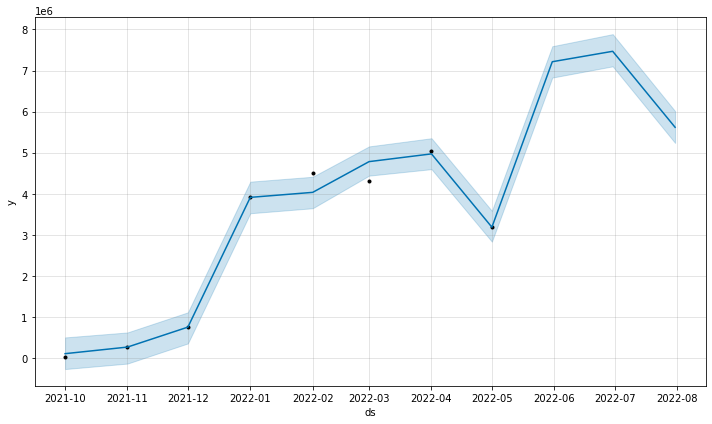

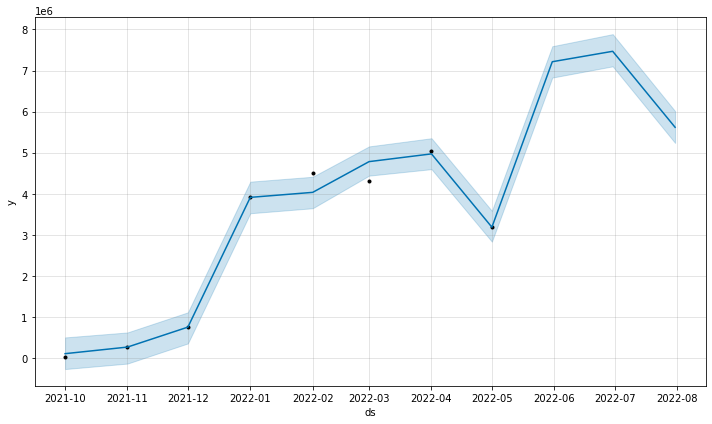

In [312]:
m.plot(prediction)